In [1]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
from scipy.ndimage.measurements import label

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
#from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

In [3]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from moviepy.video.io.VideoFileClip import VideoFileClip

# Vehicle Detection Project

The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, I also apply a color transform and append binned color features, as well as histograms of color, to the HOG feature vector.
- I also need to normalize the features and randomize a selection for training and testing.
- Implement a sliding-window technique and use the trained classifier to search for vehicles in images.
- Run pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.


# Pull in Data

In [24]:
# Read in cars and notcars
images = glob.glob('D:/Self Driving Car Engineer/P5/vehicles/KITTI_extracted/*.png', recursive=True)
images += glob.glob('D:/Self Driving Car Engineer/P5/non-vehicles/**/*.png', recursive=True)

# images are divided up into vehicles and non-vehicles 
cars = []
notcars = []

for image in images:
    if 'non-vehicles' in image:
        #notcars.append(image)
        notcars.append(mpimg.imread(image))
    else:
        #cars.append(image)
        cars.append(mpimg.imread(image))

I started by reading in all the vehicle and non-vehicle images. Here is an example of one of each of the vehicle and non-vehicle classes:

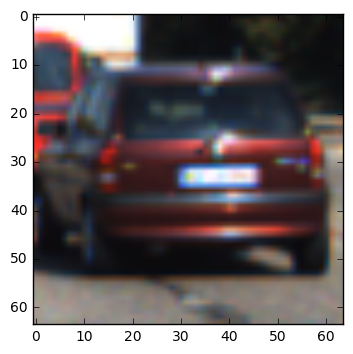

In [34]:
#car_ind = np.random.randint(0, len(cars))
car_image = cars[2]
plt.imshow(car_image)
plt.show()

Here is a picture of an example car image(above) and non car(below).

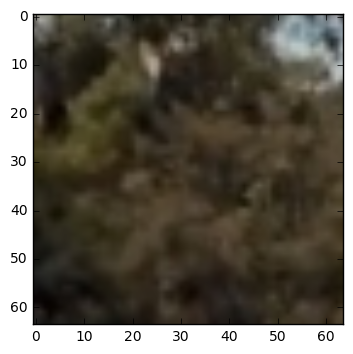

In [27]:
nocar_ind = notcars[2]
#nocar_image = mpimg.imread(notcars[nocar_ind])
plt.imshow(nocar_ind)
plt.show()

# Histogram of Oriented Gradients (HOG)
1. I will need to extract HOG features from the training images.

The code for this step is contained here. Here i am using Histogram of Oriented Gradient (HOG) features for each of the cell blocks. The gradient samples are distributed into 8 or 9 orientations (i have experimented for both). We sum up the gradients samples for each, the bigger the infulence, the bigger the 'arm direction' .

The extract feautures function takes the image then applies a color conversion (if necessary) and uses bin_spatial() and color_hist() to generate feature vectors. The colour histogram computes the histogram of the RGB channels separately.
The bin spatial function takes in an image, a color space conversion,squashes it into a smaller or desired resolution I would like to convert it to, and returns a feature vector.


In [7]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(16, 16)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features


# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=16, bins_range=(0., 1.)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features



# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='YCrCb', spatial_size=(16, 16),
                        hist_bins=16, orient=8, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []
        # Read in each one by one
        #image = mpimg.imread(file)
        #image = file
        
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


# Slide Window and Boxes 

I experimented and found that 16 by 16 pixel resolution still provides a good enough representation of a car. I also inlcuded the slide window function provided by udacity as well as the draw boxes code, which will help us places boxes around our car by scanning the image. Later on, will will set the overlap to 80% since 50% overlap results in not very accurate boxes placed around our car.

In [8]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
        
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    else:
        y_start_stop[0] = int(img.shape[0] * y_start_stop[0] / 100.)
        
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    else:
        y_start_stop[1] = int(img.shape[0] * y_start_stop[1] / 100.)
        
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-nx_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list



# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy




# Single Image Features
Here we combine the extract features with the bin spatial, histogram and hog feature extractions into one function.

In [9]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='YCrCB', spatial_size=(16, 16),
                        hist_bins=16, orient=8, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img)      
        
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [16]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='YCrCB', 
                    spatial_size=(16, 16), hist_bins=16, 
                    hist_range=(0, 256), orient=8, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))   
        
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [17]:
#save the models and trained info, so no need to retrain
scaler_value= 'C:/CarND-Transfer-Learning-Lab/P5 values/scaler.joblib.pkl'
scaled_x_value = 'C:/CarND-Transfer-Learning-Lab/P5 values/scaled_x.joblib.pkl'
svc_value = 'C:/CarND-Transfer-Learning-Lab/P5 values/svc.joblib.pkl'

In [113]:

car_features = None
notcar_features = None
X_scaler = None
scaled_X = None
svc = None

def get_features():
    global car_features, notcar_features
    
    car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
def learn_scale():
    global car_features, notcar_features, X_scaler, scaled_X
    
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    
    X_scaler = StandardScaler().fit(X)  #here we standardize/normalize the data
    joblib.dump(X_scaler, scaler_value, compress=9)  #save the value, so we dont need to do it again
    
    scaled_X = X_scaler.transform(X)  #here we scale our data
    joblib.dump(scaled_X, scaled_x_value, compress=9)  #save the value for future use  
    
def train():
    global car_features, notcar_features, scaled_X, svc
    
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    rand_state = np.random.randint(0, 100)
    
    # Split up data into randomized training and test sets
    x_train, x_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)
    
    svc = LinearSVC() # Use a linear SVC
    
    t = time.time() # Check the training time for the SVC
    svc.fit(x_train, y_train)
    t2 = time.time()
    print(round(t2 - t, 2), 'Seconds to train SVC...')
    print('Test Accuracy of SVC = ', round(svc.score(x_test, y_test), 4))
    joblib.dump(svc, svc_value, compress=9)   #save the values from SVC, so we dont need to do it again
    #return svc



# Paremeters
Here we get to tweak and modify the many parameters.

In [19]:
#######################
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

# YCrCB
YCbCR is generally regarded as the most preferred color space in uncontrolled lighting conditions. Compact color structures can be obtained under a wide range of varying lighting variations under this color space. Work done by Garcia et al [1] (reference attached) shows that YCBCr is more compact than HSV and the later color space is more sensitive to lighting variations. 

https://www.researchgate.net/publication/3424007_Face_Detection_Using_Quantized_Skin_Color_Regions_Merging_and_Wavelet_Packet_Analysis


Medical research has discovered that the human eye has different sensitivity to colour and brightness. Thus there came about the transformation of RGB to YCbCr.

Y: Luminance; Cb: Chrominance-Blue; and Cr: Chrominance-Red are the components. Luminance is very similar to the grayscale version of the original image. Cb is strong in case of parts of the image containing the sky (blue), both Cb and Cr are weak in case of a colour like green, and Cr is strong in places of occurrence of reddish colours.

# Here we get the features and train the network using a traditional linear Support Vector Classification.

In [111]:
from sklearn import svm
from sklearn import datasets
from sklearn.externals import joblib
import os

In [114]:
get_features()
learn_scale()
train()

3.25 Seconds to train SVC...
Test Accuracy of SVC =  0.9963


Here we see the SVM is quick with good accuracy.

# Train the network using a Decision Tree Classification.

In [105]:
from sklearn import tree

def train():
    global car_features, notcar_features, scaled_X, svc
    
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    rand_state = np.random.randint(0, 100)
    
    # Split up data into randomized training and test sets
    x_train, x_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)
    
    svc = tree.DecisionTreeClassifier() # Use a tree classifier 
    
    t = time.time() # Check the training time for the classifier
    svc.fit(x_train, y_train)
    t2 = time.time()
    print(round(t2 - t, 2), 'Seconds to train Tree...')
    print('Test Accuracy of Tree = ', round(svc.score(x_test, y_test), 4))
    joblib.dump(svc, svc_value, compress=9)   #save the values from SVC, so we dont need to do it again
    #return svc

In [106]:
get_features()
learn_scale()
train()

99.23 Seconds to train Tree...
Test Accuracy of Tree =  0.995


Here we see the Decision Tree Classifier is not as accurate, but much slower.

# Lets Put in an Image for testing

I have already set the window search areas to focus on 3 strips - the area where the cars are smallest, (50-70% of the image, medium cars - 50-80% and finally the cars that are closer, which represnt larger box detections - 50-90%.) I also set different box sizes - 64, 96 and 128 respectively. (increments of 32) We dont really need to detect really small cars in the distance (waste of processing power) but we could do this for pedestrians detection!

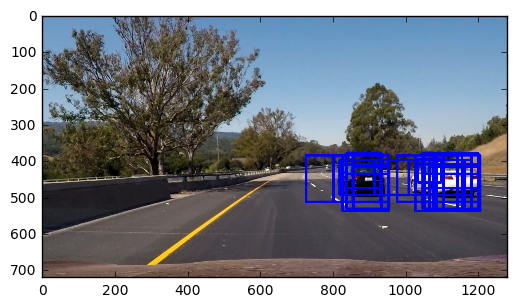

In [115]:
###################### lets experiment with 1 image!!!  
image = mpimg.imread('D:/Self Driving Car Engineer/P5/CarND-Vehicle-Detection-master/test_images/test6.jpg')

draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255
##########################################



#different window sizes for the cars
window_sizes = [64,96,128,]

#We search 3 sections of the image, from the centre of road, all the way to front of camera
y_start_stop = [[50, 70],[50, 80],[50, 90],  ]

#Here we search for the multiple window sizes
windows = []
for i in range(len(window_sizes)):
    windows += slide_window(
        image, x_start_stop=[None, None], y_start_stop=y_start_stop[i],
        xy_window=(window_sizes[i], window_sizes[i]), xy_overlap=(0.8, 0.8))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)               

plt.imshow(window_img)
plt.show()

- As you can see, the classfifier managed to select many of the boxes with the correct hog features, and we will try and clean up these boxes in the next steps.

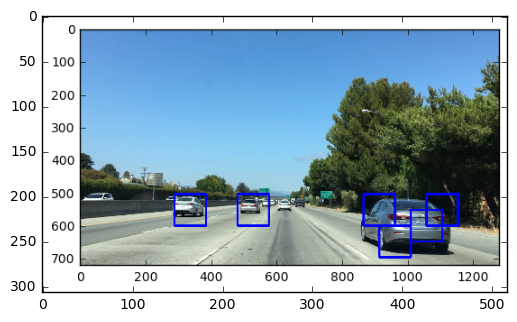

In [108]:
e = mpimg.imread('D:/Self Driving Car Engineer/P5/P5_HLS_2.png')
f = mpimg.imread('D:/Self Driving Car Engineer/P5/P5_HLS_orient8_ALL.png')
g = mpimg.imread('D:/Self Driving Car Engineer/P5/P5_smaller windows.png')
fig = plt.figure()
plt.imshow(e)
plt.show()

- Using the basic 50% overlap does not produce any meaningful results. Testing on a more crowded car scene image.

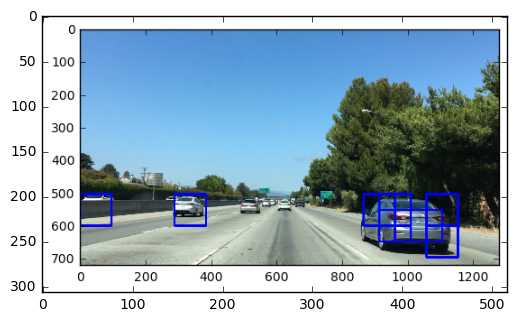

In [109]:
plt.imshow(f)
plt.show()

Here I play around with the parameters. I get the wanted result as shown below:

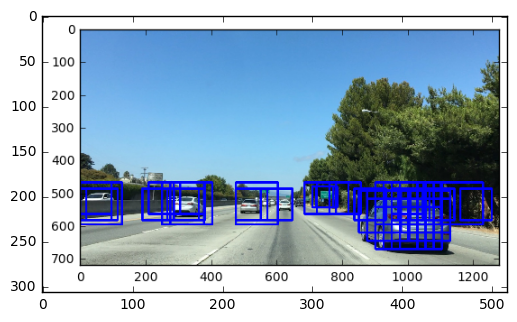

In [36]:
plt.imshow(g)
plt.show()

# Important Notes:
Here it is clear than there are many false positives. The classifier is so good that it can actually detect cars in the opposite lane! The downside is the classifier is now too sensitive and will detect hard rectangular objects such as the highway signs. Some further tweaking maybe needed. I finally settled with 80% overlap.

# Hog Classify Visualization

We calculate the hog features and classify using this visualization.  Now let's try classifying with HOG features and see how well we can do. Some examples of the hog visualization can be seen with cars and non car data. Even with spatial binning of 16, the result is still pretty good and we can see the difference between car and non-car features.

In [93]:
gray = cv2.cvtColor(cars[2], cv2.COLOR_RGB2GRAY)
features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

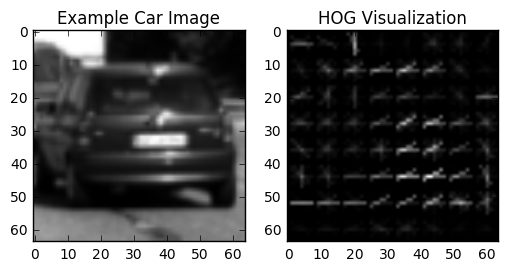

In [138]:
fig = plt.figure()
plt.subplot(121)
plt.imshow(gray, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.show()

In [63]:
gray = cv2.cvtColor(notcars[2], cv2.COLOR_RGB2GRAY)
features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

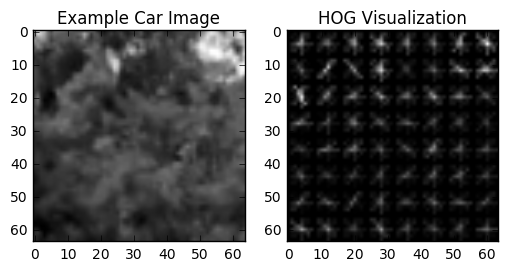

In [64]:
fig = plt.figure()
plt.subplot(121)
plt.imshow(gray, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.show()

# YCrCB
Here we convert the example image into YCrCB colour space.

In [94]:
yimage = cv2.cvtColor(cars[2], cv2.COLOR_RGB2YCrCb)
#features, hog_image = get_hog_features(yimage, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
#plt.imshow(yimage)
#plt.show()

In [77]:
def color_hist_single_ch(img, nbins=16, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    ch_hist = np.histogram(img, bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = ch_hist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Return the individual histogram and bin_centers
    return ch_hist, bin_centers

In [83]:
image = cv2.imread('D:/Self Driving Car Engineer/P5/vehicles/KITTI_extracted/951.png') # in BGR
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
luv = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
xyz = cv2.cvtColor(image, cv2.COLOR_RGB2XYZ)
yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
ycc = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

color_spaces_names = ['rgb', 'hsv', 'hls', 'luv', 'lab', 'xyz', 'yuv', 'ycc']
color_spaces = [image, hsv, hls, luv, lab, xyz, yuv, ycc]

rows = len(color_spaces)

fig, axis = plt.subplots(rows, 4, figsize=(12, 3*rows))
for row, colorspace in enumerate(color_spaces):
    axis[row, 0].set_title(color_spaces_names[row])
    axis[row, 0].imshow(colorspace)
    axis[row, 0].axis('off')
    for ch in range(3):
        ch_hist, bincen = color_hist_single_ch(colorspace[:,:,ch], nbins=16, bins_range=(0, 256))
        axis[row, ch + 1].set_title(color_spaces_names[row][ch])
        axis[row, ch + 1].bar(bincen, ch_hist[0])

# Colour Visualisation
Here are more examples of the different colour spaces, split into thier colour channels histograms. The code has been kindly provided by udacity.

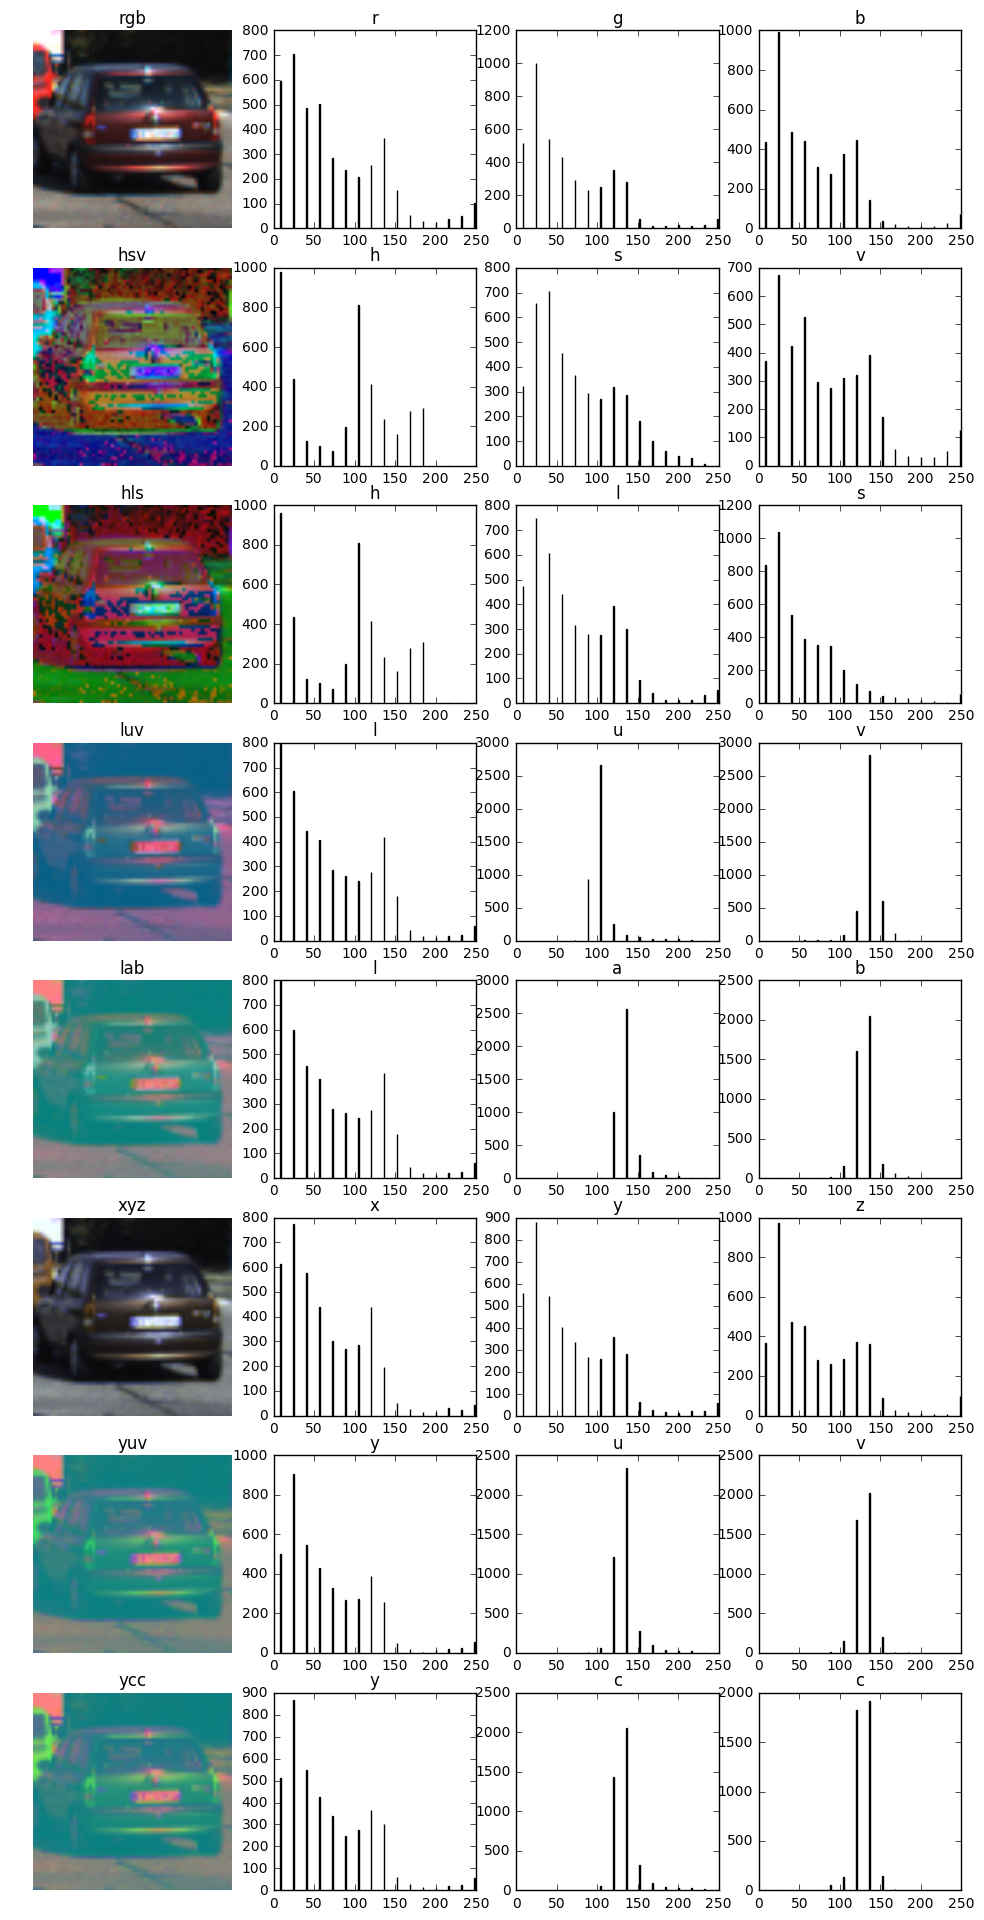

In [84]:
plt.show()

# YCrCB
The top graph shows the YCC, LAB and YUV have very similar histograms. 


In [87]:
def hog_examples_drawing(image, color_space=color_space, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(image)


    fig, axarr = plt.subplots(1, 4, figsize=(12,3))
    axarr[0].set_title('original')
    axarr[0].imshow(image)

    _, ch_0 = get_hog_features(feature_image[:,:,0], orient, pix_per_cell, cell_per_block, vis=True)
    axarr[1].set_title('Channel 0')
    axarr[1].imshow(ch_0, cmap='jet')

    _, ch_1 = get_hog_features(feature_image[:,:,1], orient, pix_per_cell, cell_per_block, vis=True)
    axarr[2].set_title('Channel 1')
    axarr[2].imshow(ch_1, cmap='jet')

    _, ch_2 = get_hog_features(feature_image[:,:,2], orient, pix_per_cell, cell_per_block, vis=True)
    axarr[3].set_title('Channel 2')
    axarr[3].imshow(ch_2, cmap='jet')

# HOG Visualisation
Here are more examples of the different colour spaces HOG's. The code has been kindly provided by udacity.

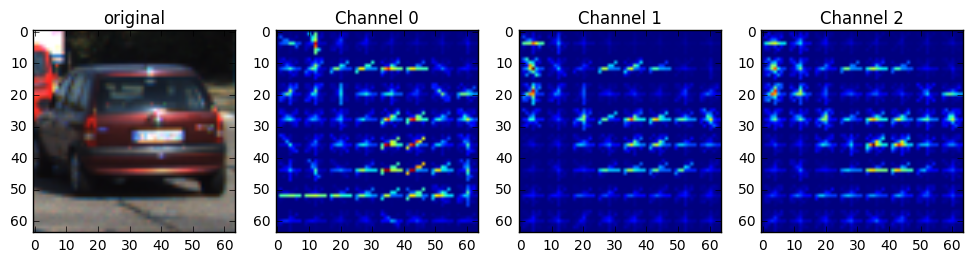

In [90]:
hog_examples_drawing(image)
plt.show()

- Notice how both colour thresholds slightly classify the edges of the other red car. This seems to be more dominant in the RGB values, (channels 2 and 3).

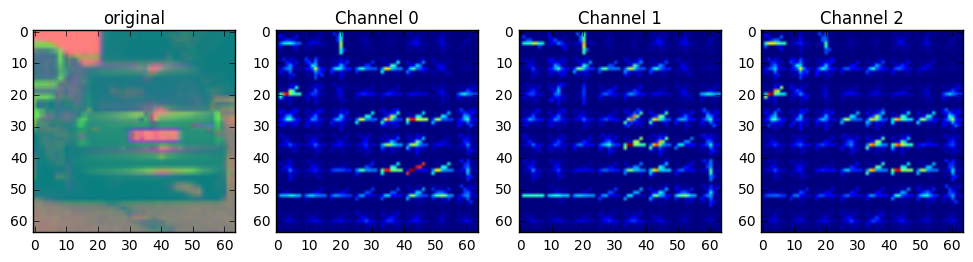

In [91]:
hog_examples_drawing(yimage)
plt.show()

- Here we see the YCrCb channel performing slitghly better in Channel 1, with the outline more defined.

# False Positives and Cleaning up the image
To deal with the many false positives, we will use udacity's heat mapping solution to overlap boxes, and exclude the weaker ones, by comparing 1 frame from the next few. We will also compute a 'heatmap' that will produce a final, single bounding box around the car.

In [122]:
import collections
import numpy as np
from scipy.ndimage.measurements import label

boxes_list = collections.deque(maxlen=10)

def add_boxes(boxes):
    boxes_list.append(boxes)

def add_heat(img):
    heatmap = np.zeros_like(img[:, :, 0]).astype(np.float)

    for frame_boxes in boxes_list:
        for box in frame_boxes:
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return apply_threshold(heatmap, 10)


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [123]:
def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1] + 1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
    return img

# Heatmapping and Visulization
To deal with the many false positives, we will use udacity's heat mapping solution to create overlaying boxes, and exclude the weaker ones, by comparing 1 frame from the next few. We will also compute a 'heatmap' that will produce a final, single bounding box around the car.

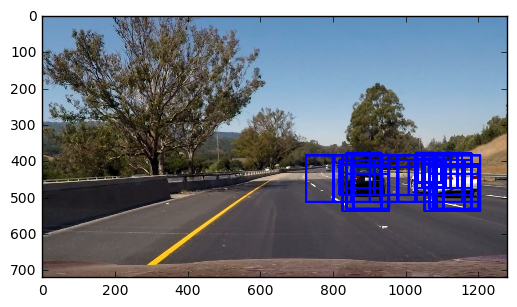

In [459]:
plt.imshow(window_img)
plt.show()

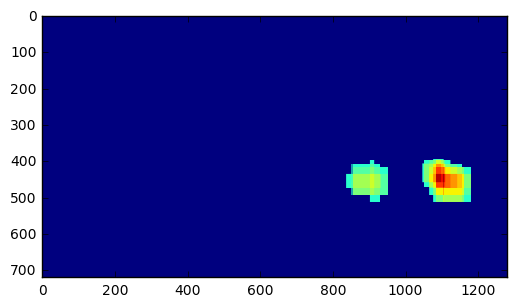

In [462]:
#heat = np.zeros_like(window_img[:,:,0]).astype(np.float)
add_boxes(hot_windows)
heat = add_heat(window_img)
plt.imshow(heat)
plt.show()

Here I compute the heatmaps and turn them into black to better distinguish them. I also experimented with the different thresholds and settled with the value of 14.

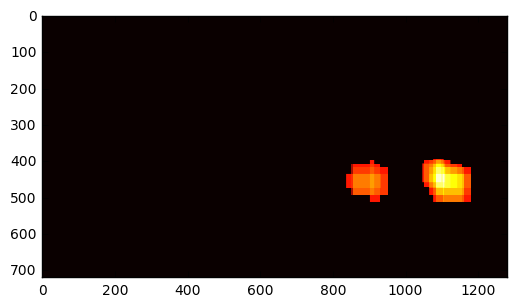

In [463]:
heatmap = np.clip(heat, 0, 255)
plt.imshow(heatmap, cmap='hot')
plt.show()

2 cars found


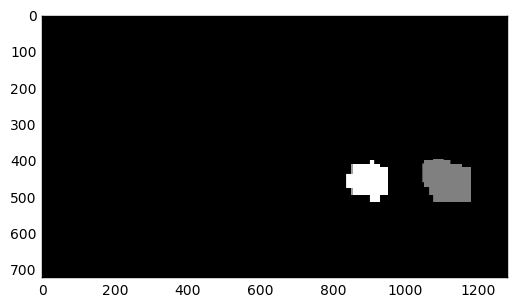

In [464]:
#heatmap = apply_threshold(heatmap, 7 )

labels = label(heatmap)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')
plt.show()

- Here we finally get the heatmap to detect the 2 cars. Many thanks to udacity's code for this.

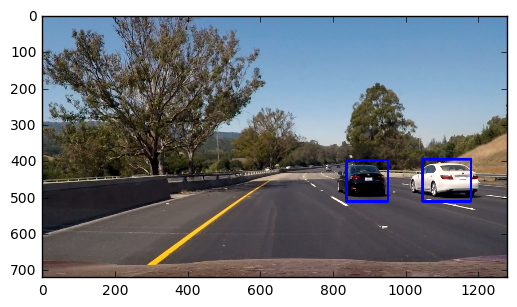

In [465]:
# Read in the last image above
#image = mpimg.imread('img105.jpg')
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(draw_image, labels)
# Display the image
plt.imshow(draw_img)
plt.show()

Hooray! We detected our 2 cars!!

# Final Pipeline

Here I create a final pipeline, which will do all of the steps I mentioned above in one process. Now if we feed in a raw image, it shoud output a copy of the image with the bounding boxes. Our final step is to tell the algorithm where we should search the image. Obviously we do not expect cars in the sky, so i search from the bottom half of the image. Since a video is a series of raw images, once we put in the video file, we should be complete.

# Normalization

As our images may have poor contrasts, it was necessary to normalize the images. Poor contrast due to glare etc, which in the project video we can clearly see the differences in sunny parts of the road. 

In [124]:
def process_image(img):
    
    draw_image = np.copy(img)
    img = img.astype(np.float32)/255
    
    
    
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)   
    
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
    
    add_boxes(hot_windows) #need to add boxes here, for my boxes set
    
    #heatmap = add_heat(window_img) #img or window_img??
    
    heat = add_heat(window_img)
    
    heatmap = np.clip(heat, 0, 255)
    heatmap = apply_threshold(heatmap, 10 )
    
    labels = label(heatmap)

    return draw_labeled_bboxes(draw_image, labels)


In [125]:
image = mpimg.imread('D:/Self Driving Car Engineer/P5/CarND-Vehicle-Detection-master/test_images/test6.jpg')
#image = image.astype(np.float32)/255

# Defining Window Search Area

In [126]:
#different window sizes for the cars
window_sizes = [64,96,128,]

#We search 3 sections of the image, from the centre of road, all the way to front of camera
y_start_stop = [[50, 70],[50, 80],[50, 90],  ]

#Here we search for the multiple window sizes
windows = []
for i in range(len(window_sizes)):
    windows += slide_window(
        image, x_start_stop=[None, None], y_start_stop=y_start_stop[i],
        xy_window=(window_sizes[i], window_sizes[i]), xy_overlap=(0.8, 0.8))

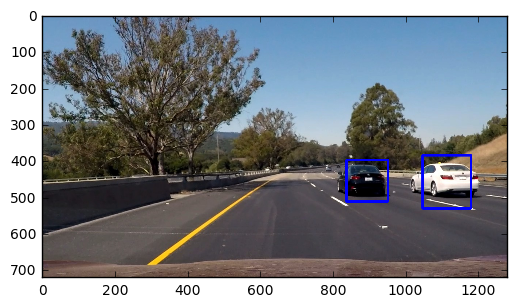

In [127]:
process_image(image)
plt.imshow(process_image(image))
plt.show()


# Let's Try The Final Pipeline on a small section!

In [128]:
video = 'D:/Self Driving Car Engineer/P5/CarND-Vehicle-Detection-master/project_video'
white_output = '{}_test.mp4'.format(video)

#try out on a short clip first
clip = VideoFileClip('{}.mp4'.format(video)).subclip(5, 8)


In [129]:
white_clip = clip.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video D:/Self Driving Car Engineer/P5/CarND-Vehicle-Detection-master/project_video_test.mp4
[MoviePy] Writing video D:/Self Driving Car Engineer/P5/CarND-Vehicle-Detection-master/project_video_test.mp4


 99%|█████████████████████████████████████████▍| 75/76 [10:47<00:08,  8.49s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: D:/Self Driving Car Engineer/P5/CarND-Vehicle-Detection-master/project_video_test.mp4 

Wall time: 10min 48s


# Video

Here is the link from my googlge drive - https://drive.google.com/open?id=0B7wHdgyuTB_lUU1ySUVnN3g2Yzg

# Final Pipeline Video

In [26]:
video = 'D:/Self Driving Car Engineer/P5/CarND-Vehicle-Detection-master/project_video'
white_output = '{}_testfinal.mp4'.format(video)

#try out on a short clip first
clip = VideoFileClip('{}.mp4'.format(video))

In [27]:
white_clip = clip.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video D:/Self Driving Car Engineer/P5/CarND-Vehicle-Detection-master/project_video_testfinal.mp4
[MoviePy] Writing video D:/Self Driving Car Engineer/P5/CarND-Vehicle-Detection-master/project_video_testfinal.mp4


100%|███████████████████████████████████▉| 1260/1261 [2:43:03<00:07,  7.59s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: D:/Self Driving Car Engineer/P5/CarND-Vehicle-Detection-master/project_video_testfinal.mp4 

Wall time: 2h 43min 4s


# Video
Here is my final pipeline:
https://drive.google.com/open?id=0B7wHdgyuTB_ldERFWFNYM3ZvdjQ 

# Final Thoughts and Discussion
As mentioned when I was testing my parameters for the crowded car image, the problem is tweaking the algorthim so that it was good enough to detect cars, but not too strong so that it will detect large, rectangular traffic signs. I looked at my test video and realised that there were still many false positives in certain frames of the image. This could be fixed by playing around with the colour scales and detections, but I detect some very major problems:

- How will the classifier react to urban areas with many rectangular objects of major colour contrasts? Signs, shop flags etc.
- The classifier will not behave and could fail to detect cars of more exotic proportions, in addition to many weird hot rods, classic cars, motorcyclists and perhaps even construction vehicles.
- Will this classifier even work at night where there is poor lighting which could affect the colour and gradient detection methods.
- This classifier is still scanning the bottom portion of the road, and not looking at hazards from above like truck-trailers. (i menitoned this in my first project) Such as the fatal Tesla autopilot incident involving Joshua Brown.
- How will this classifier behave in foggy and extreme weather conditions? Probably not very well due to poor lighting and gradients (the white blizzards and snow could affect gradient and colour feature extractions)



# Possible Improvements

I can also cut off your image on x-axis. I am not interested for example in part of image for opposite lane. So on x-axis I can cut off image somewhere between 400 and 500 pixels. I chose the SVM classifier as it was faster and produced a slighlty higher accuracy. Changing the number of orientations to 9 or increasing the spatial bins to 32 by 32 pixels could be possible improvements at the cost of performance. 

Alternatively I could apply what I've learned in the behvaioral cloning project classifier and create a deeper and better network to better classify cars/non cars. Also, for better training, I would need to apply some changes to the raw KDDI images, such as removing contrast/adding random brightness and mirroring images 50% to prevent over fitting. 


